### Introduction and data load

This is the Satander product recommendation Kaggle challenge. 1.5 years of customer data is available. The task is to relate customer features up to May 2016 to predict June 2016 product ownership.

For ease of interpretation, I've converted most of the feature space from Spanish to English. However, the product names will remain in Spanish to maintain compatability with Kaggle's submission-scoring system.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
import xgboost as xgb
from helper_functions import *
%load_ext autoreload
%autoreload 2

In [2]:
dtype = {'conyuemp': 'object'}
parse_dates = ['fecha_dato', 'fecha_alta', 'ult_fec_cli_1t']

df_train = pd.read_csv('train_ver2.csv', dtype=dtype, parse_dates=parse_dates)
df_holdout = pd.read_csv('test_ver2.csv', dtype= dtype, parse_dates=parse_dates)

D:\Users\joeft\Anaconda3\envs\fastai\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (5,8,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
product_column_names = list(df_train.loc[:, 'ind_ahor_fin_ult1':'ind_recibo_ult1'].columns)
spanish_to_english_features = {'fecha_dato': 'date',
                              'ncodpers': 'customer_code',
                              'ind_empleado': 'employee_index',
                              'pais_residencia': 'country_of_residence',
                              'sexo': 'gender',
                              'age': 'age',
                              'fecha_alta': 'initiation_date',
                              'ind_nuevo': 'is_new_customer',
                              'antiguedad': 'customer_seniority',
                              'indrel': 'is_primary_customer',
                              'ult_fec_cli_1t': 'last_date_as_customer',
                              'indrel_1mes': 'customer_type_1m',
                              'tiprel_1mes': 'customer_relation_1m',
                              'indresi': 'is_local_resident',
                              'indext': 'is_foreigner',
                              'conyuemp': 'is_spouse_of_employee',
                              'canal_entrada': 'channel_used_to_join',
                              'indfall': 'is_deceased',
                              'tipodom': 'address_type',
                              'cod_prov': 'province_code',
                              'nomprov': 'province_name',
                              'ind_actividad_cliente': 'activity_index',
                              'renta': 'gross_household_income',
                              'segmento': 'college_education',                           
                              }

df_train.rename(columns = spanish_to_english_features, inplace=True)
df_holdout.rename(columns = spanish_to_english_features, inplace=True)


## Exploratory Data Analysis:

EDA is difficult with 24 different products. Fortunately, many of them are extremely rarely purchased (gaurantees, med/short term deposits, savings accounts). The most common product purchased is 'ind_recibo_ult1', or a direct debit account, opened at ~1% rate between months. Pensions, payroll, credit card, and current accounts are also common.

Here, EDA could be done forever. But let's test some simple hypotheses to see what kind of features might be useful.

### Which date to train on?

The goal is to predict ownership of new products in June, 2016. The most recent feature-target space available is May, 2016. However, seasonal trends may hurt generalization of this model. Alternatively, since 1.5 years of data are available, June 2015 could by hypothesized to better reflect the behaviour of June 2016.

Overall, I tried both. My score using May, 2016 was 0.024, while using June 2015 gave 0.029. Let's see if we can find out if there are significant seasonal trends that explain this difference.

For the training set, we need to be more careful, but here I'll perform and inner join between date-pairs (dropping some customers) and also drop the very small number of null values for product ownership.

Three date ranges are compared:
1. April-May 2015
2. April-May 2016
3. May-June 2015

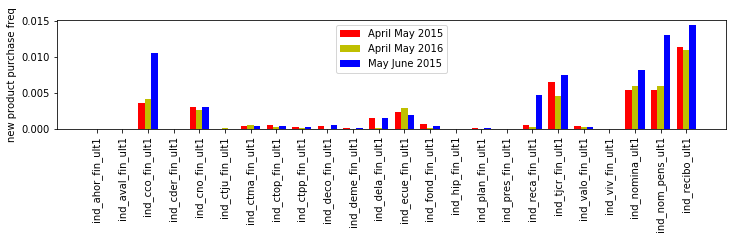

In [4]:
dates = [('2015-04-28','2015-05-28'), ('2016-04-28','2016-05-28'), ('2015-05-28', '2015-06-28')]
frequencies = []
product_cols = df_train.loc[0:1,'ind_ahor_fin_ult1':'ind_recibo_ult1'].columns

for date in dates:
    df_time_delta = pd.merge(df_train[df_train['date']==date[0]], 
                                df_train[df_train['date']==date[1]], 
                                on = 'customer_code', how = 'inner',
                                suffixes=('', '_future'))
    target = df_time_delta[product_cols + '_future'].values - df_time_delta[product_cols].values
    target = target[~np.isnan(target).any(axis=1)]
    target = np.where(np.less(target,0), 0, target)
    frequencies.append(np.sum(target, axis = 0)/target.shape[0])
    
    
ind = np.arange(target.shape[1])
fig, ax = plt.subplots(figsize = (12,2))
rects1 = ax.bar(ind, frequencies[0], 0.25, color='r')
rects2 = ax.bar(ind + 0.25, frequencies[1], 0.25, color='y')
rects3 = ax.bar(ind + 0.5, frequencies[2], 0.25, color='b')
ax.legend((rects1[0], rects2[0], rects3[0]), ('April May 2015', 'April May 2016', 'May June 2015'))
ax.set_xticks(ind + 0.5 / 2)
ax.set_xticklabels(product_cols)
plt.xticks(rotation=90)
plt.ylabel('new product purchase freq')
plt.show()

This chart is trying to answer whether seasonal trends or yearly trends are more important. In general, differences between April-May in 2015/2016 (red/yellow) are small. However, May-June (blue) shows significantly higher purchase frequencies for several products, indicating that seasonal trends dominate. I am still glad I tested models built from both periods, but this supports my final approach of training on May-June 2015.

## Feature engineering

Most of the feature engineering is done from functions imported from helper_functions.py. The function below generated a feature space from month N, and target space from month N+1. Note that target space is the positive difference in products owned in N+1 and N. Products owned in months in and before N are fair game, and indeed constitute some of the most important features.

Several boolean columns have 'S' or 'N', which are converted to 1/0. Other columns have strange values for NaN (ex: '     NA'). Still other categorical features have hundreds of categories, and limiting these to the top ~10 categories is useful to reduce feature space dimensionality. 

In [5]:
X, y = variable_transforms(df_train, '2015-05-28', '2015-06-28', 6)
eda_df = pd.concat([X, y.add_suffix('_future')], axis=1)

D:\kaggle\satander\helper_functions.py:38: RuntimeWarning: invalid value encountered in greater_equal
  y = pd.DataFrame(np.where(dy>=0, dy, 0), columns=y_present.columns)


##### Gross household income

This is one of the most obvious financial features available. Unfortunately, about 1/4th of the gross household income values are null. For non-null incomes, there is a moderate trend towards purchasing direct debit accounts. Additionally, the null-valued incomes purchase debit accounts at a higher rate, indicating preditive value of this feature.

purchase rate for null income: 0.0117
purchase rate for nonnull income: 0.0149


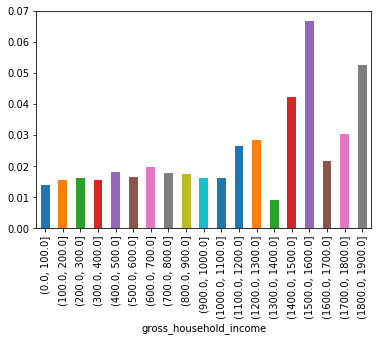

In [6]:
rate_null = eda_df[eda_df['gross_household_income'].isnull()]['ind_recibo_ult1_future'].sum()/eda_df['gross_household_income'].isnull().sum()
rate_nonnull = eda_df[eda_df['gross_household_income'].notnull()]['ind_recibo_ult1_future'].sum()/eda_df['gross_household_income'].notnull().sum()
print('purchase rate for null income: {}\npurchase rate for nonnull income: {}'.format(round(rate_null,4), round(rate_nonnull,4)))
eda_df.groupby(pd.cut(eda_df['gross_household_income']/1e3, np.arange(0, 2e3, 1e2)))['ind_recibo_ult1_future'].mean().plot.bar()
plt.show()

#####  Age and pensions:

We expect there to be a positive relationship between age and pension product acquisition. The 30+ group gets a pension product most frequently, although this drops off with age. The interpretation here is pensions are primarily purchased by those at the beginning-of-the-end of careers. Due to the "U" relationship between age and purchases, logistic regression won't get much use out of this feature. A new engineered field (ex: age_dist_from_30) could help to linearize the relationship, but I plan to use decision tree methods for my final result.

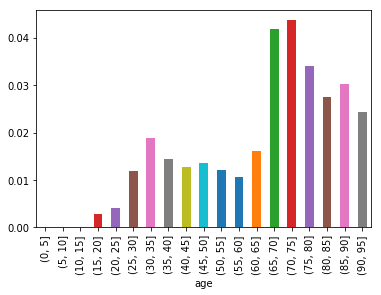

In [7]:
eda_df.groupby(pd.cut(pd.to_numeric(eda_df['age'], errors = 'coerce'), np.arange(0, 100, 5)))['ind_nom_pens_ult1_future'].mean().plot.bar()
plt.show()

#####  Country of residence:

During data cleaning, I created a new column with 0 or 1 to signify whether a customer was local to Spain. Luckily, locals appear to purchase new debit accounts at twice the rate compared to foreign residents. 

The difference persists for other banking products. However, there is limited utility in exploring this feature since 99.5% of residents are local. 

In [8]:
eda_df.groupby('local_residence')['ind_recibo_ult1_future'].mean()

local_residence
0    0.005604
1    0.014432
Name: ind_recibo_ult1_future, dtype: float64

##### Customer gender

Rate of debit account purchases varies reliably with gender.

In [9]:
eda_df.groupby('gender')['ind_recibo_ult1_future'].mean()

gender
0    0.011380
1    0.016815
Name: ind_recibo_ult1_future, dtype: float64

##### Activity index: 

Another boolean column, active customers are significantly more likely to purchase a debit account. 

In [10]:
eda_df.groupby('activity_index')['ind_recibo_ult1_future'].mean()

activity_index
0.0    0.001091
1.0    0.025299
Name: ind_recibo_ult1_future, dtype: float64

##### College education:

Increasing level of education seems to decrease likelihood of product purchase. There are null values, but they make up less than 1% of entries.

In [11]:
eda_df.groupby('college_education')['ind_recibo_ult1_future'].mean()

college_education
01 - TOP              0.024221
02 - PARTICULARES     0.018068
03 - UNIVERSITARIO    0.007077
Name: ind_recibo_ult1_future, dtype: float64

## Data cleaning and model evaluation

The basic workflow is:

1. Perform a train-test split on the data
2. Impute null or missing values by using medians from the training set (avg not appropriate for 0/1 columns)
3. Fit the model on the training set
4. Evaluate on testing set
5. Repeat with different features and models until a good result is reached

Evaluation is done using "Mean Average Precision @ 7". I found [Kaggle's explanation](https://www.kaggle.com/c/santander-product-recommendation#evaluation) to be confusing, likely because many of the terms are left undefined. Luckily, [this blog post](https://medium.com/@pds.bangalore/mean-average-precision-abd77d0b9a7e) explains what they meant in more detail. Qualitatively, the metric asks for your top 7 predictions in order of likelihood. The score is higher if the true purchased products are in your list, and if your list ranks them near the top.

Winning scores were around MAP@7 = 0.03 (higher is better).

The final feature space used below was arrived at after a few iterations. Features were tested and evaluated as significant based on change in model score, as well as the built-in feature_importances_ metric that is common to decision tree modules.

Continuous features can be used as-is. Categorical variables must be one-hot-encoded - i.e., spread across several boolean columns.

We keep track of products already owned so that we can mask out predicted probabilities in the final recommendation. Furthermore, some products are so uncommonly purchased that a train-test-split often leaves 0 positive examples in the training set. These products are dropped, as no training can be done on them. This typically drops ~3 products.

In [12]:
continuous_vars = ['gross_household_income', 
                   'age', 
                   'gender', 
                   'customer_seniority',
                   'is_foreigner',
                   'activity_index',
                   'income_isnull',
                   'local_residence'
                  ]
cat_vars = ['college_education']
dummies = pd.get_dummies(X[cat_vars])
X = pd.concat([X.drop(cat_vars, axis = 1), dummies], axis = 1)
past_owned_columns = X.loc[:,'ind_ahor_fin_ult1_past_owned':'ind_recibo_ult1_past_owned'].columns

In [13]:
feature_space = continuous_vars + list(dummies.columns) + list(past_owned_columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
products_owned_train = X_train.loc[:,'ind_ahor_fin_ult1':'ind_recibo_ult1']
products_owned_test = X_test.loc[:,'ind_ahor_fin_ult1':'ind_recibo_ult1']

In [14]:
products_with_no_training_examples = y_train.columns[y_train.mean() == 0]
y_train = y_train.drop(products_with_no_training_examples, axis = 1)
y_test = y_test.drop(products_with_no_training_examples, axis = 1)
products_owned_train = products_owned_train.drop(products_with_no_training_examples, axis = 1)
products_owned_test = products_owned_test.drop(products_with_no_training_examples, axis = 1)
products_owned_columns = list(products_owned_train.columns)
feature_space += products_owned_columns

X_train = X_train[feature_space]
X_test = X_test[feature_space]

imputer = Imputer(strategy='median')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

Gradient boosted decision trees are chosen to predict new product ownership (classification). Logistic regression was tried, but scored below 0.02 MAP@7. I briefly considered using matrix factorization methods (SVD, NMF), but the width of the product ownership matrix is only 24. I don't think it would perform well, but I haven't tested it.

A one-vs-rest classifier was used, which trains an independent estimator for each class. This improves the interpretability of the model and yields reasonable computation speed.

Probabilities for each class are predicted, and products already owned are masked out. The probabilities are then sorted to return the top 7 guesses for which product a customer will buy in the N+1th month!

In [15]:
tree_mod = xgb.XGBClassifier(n_estimators = 50, max_depth = 3, learning_rate=0.2)
classifier_tree = OneVsRestClassifier(tree_mod, n_jobs = -2) 
classifier_tree.fit(X_train, y_train)
y_pred_proba = classifier_tree.predict_proba(X_test)
y_pred_proba = y_pred_proba*(1-products_owned_test.values) # set p=0 for products owned
print('MAP@7 score: {}'.format(round(mean_avg_precision_at_7(y_test, y_pred_proba),4)))

MAP@7 score: 0.0457


Average feature importance over all estimators is displayed below. In decision tree methods, feature importance is the normalized increase in purity from splits done on that feature. 

While customer seniority, age, and household income are all great predictive features, including present and past ownership of products is what gave the model a large gain in performance. While the importance scores are medium/low, there are ~21 different columns for the products "feature".

In [16]:
estimators = classifier_tree.estimators_
feat_imps = [estimator.feature_importances_ for estimator in estimators]
feat_imps = [imps for imps in feat_imps if not np.any(np.isnan(imps))]
feat_imps = np.mean(feat_imps, axis = 0)
idx_importance = np.argsort(feat_imps)[::-1]

for idx in idx_importance[:20]:
    print(feature_space[idx], round(feat_imps[idx],3))

customer_seniority 0.194
age 0.113
gross_household_income 0.089
activity_index 0.066
ind_recibo_ult1 0.034
ind_cno_fin_ult1 0.028
ind_cco_fin_ult1 0.025
ind_dela_fin_ult1 0.023
college_education_01 - TOP 0.021
ind_tjcr_fin_ult1 0.021
ind_nom_pens_ult1 0.02
ind_cder_fin_ult1_past_owned 0.02
ind_ecue_fin_ult1 0.019
ind_viv_fin_ult1_past_owned 0.019
ind_nomina_ult1 0.019
ind_tjcr_fin_ult1_past_owned 0.019
ind_dela_fin_ult1_past_owned 0.017
ind_pres_fin_ult1_past_owned 0.015
ind_valo_fin_ult1 0.014
ind_nom_pens_ult1_past_owned 0.013


## Final prediction

First, the model is re-trained on the entire training set.

In [17]:
X_train_final = np.concatenate((X_train,X_test), axis=0)
y_train_final = np.concatenate((y_train, y_test), axis = 0)
classifier_tree.fit(X_train_final, y_train_final)

OneVsRestClassifier(estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          n_jobs=-2)

The goal is to predict new product ownership in June 2016. Contemporary demographic and customer information is available for June, but not product ownership. Past product ownership is pulled from the training dataset, May 2016.

In [18]:
X_holdout = variable_transforms_no_future(df_holdout, df_train, '2016-06-28', 6)

In [19]:
dummies = pd.get_dummies(X_holdout[cat_vars])
X_holdout.drop(cat_vars, axis = 1, inplace = True)
X_holdout = pd.concat([X_holdout, dummies], axis = 1)
products_owned_holdout = X_holdout.loc[:,'ind_ahor_fin_ult1':'ind_recibo_ult1']
customer_code_holdout = X_holdout['customer_code']
products_owned_holdout = products_owned_holdout.drop(products_with_no_training_examples, axis = 1)
X_holdout = X_holdout[feature_space]
X_holdout = imputer.transform(X_holdout)
y_holdout_pred_proba = classifier_tree.predict_proba(X_holdout)
y_holdout_pred_proba = y_holdout_pred_proba*(1-products_owned_holdout.values)

In [20]:
prod_names = y_train.columns
predictions = np.fliplr(np.argsort(y_holdout_pred_proba, axis = 1))
predictions = predictions[:,:7]
final_predictions = pd.DataFrame(columns=['ncodpers', 'added_products'])
final_predictions['added_products'] = list(y_train.columns[predictions])
final_predictions['added_products'] = final_predictions['added_products'].apply(lambda x: " ".join(x))
final_predictions['ncodpers'] = customer_code_holdout

In [21]:
final_predictions.to_csv('JT_june_2016_predictions_final.csv', index = False)

The csv can be submitted to the [Kaggle leaderboard](https://www.kaggle.com/c/santander-product-recommendation/leaderboard) for this competition. I got 0.0292 MAP@7, which is pretty good for a few days work!

![Kaggle submission](kaggle_screencap.PNG)

The winning scores are all about 0.031 MAP@7. I am no expert Kaggler, but these scores are typically reached over the course of weeks, making small tweeks to the model to eek out the extra points. If I were to continue this assignment, I would take a much harder look at feature engineering, and definitely re-investigate my major assumption that May-June 2015 is the best training set. It's possible that yearly trends could be incorporated somehow to better predict June 2016. Yearly trends probably explain the difference between MAP@7 = 0.045 in training, and 0.029 in testing.

If you read this far, thanks! I had fun, and definitely learned never to underestimate nuances in time-series data.